## Load dependencies and data file

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data (replace 'file.csv' with your actual file path)
complete_df = pd.read_csv('Resources/complete_data.csv')

# Convert 'Date' column to datetime format
complete_df['Date'] = pd.to_datetime(complete_df['Date'], errors='coerce')

# Display the first few rows
complete_df.head()

,Date,Index SA,Redfin HPI MoM,Case Shiller Index MoM,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_Year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.00%,-0.00048,30,state,23,f,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.00%,-0.00048,30,state,10,f,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000636,-0.000240,3.915,True,True,True
2,2012-01-01,59.9,0.00%,-0.00048,30,state,42,f,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.00%,-0.00048,30,state,47,f,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000528,0.000734,3.915,True,True,True
4,2012-01-01,59.9,0.00%,-0.00048,30,state,12,f,New Jersey,New Jersey,...,0.000549,0.000502,0.0,0.007897,0.001832,0.006060,3.915,False,False,True


# Complete pre-processing

In [2]:
# Convert categorical columns using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 'region', 'state', 'property_type'], drop_first=True)

In [3]:
# Clean and convert any Percentage Strings
complete_df['Redfin HPI MoM'] = complete_df['Redfin HPI MoM'].str.rstrip('%').astype(float) / 100

In [4]:
# Fill any missing values with the mean
complete_df = complete_df.fillna(complete_df.mean())

In [5]:
# Select only numeric columns from the DataFrame
numeric_df = complete_df.select_dtypes(include=[np.number])

constant_columns = [col for col in numeric_df.columns if numeric_df[col].nunique() == 1]
print(f"Columns with constant values: {constant_columns}")

Columns with constant values: ['period_duration']


In [6]:
for col in numeric_df.columns:
    print(f"{col}: Min = {numeric_df[col].min()}, Max = {numeric_df[col].max()}")

Index SA: Min = 59.9, Max = 172.1
Redfin HPI MoM: Min = -0.0012, Max = 0.019
Case Shiller Index MoM: Min = -0.00697, Max = 0.0189
period_duration: Min = 30, Max = 30
table_id: Min = 1, Max = 51
median_sale_price: Min = 7000, Max = 3275000
median_sale_price_mom: Min = -0.913, Max = 22.15270935960591
median_sale_price_yoy: Min = -0.9413467741935484, Max = 12.571428571428571
median_list_price: Min = 53000.0, Max = 4700000.0
median_list_price_mom: Min = -0.7438838754720863, Max = 3.5786441713492305
median_list_price_yoy: Min = -0.7250752500270485, Max = 3.630526176098192
median_ppsf: Min = 3.0, Max = 40906.0
median_ppsf_mom: Min = -0.9974014314844518, Max = 312.172894350185
median_ppsf_yoy: Min = -0.9976036845276812, Max = 243.25566423457764
median_list_ppsf: Min = 27.0, Max = 1873.0
median_list_ppsf_mom: Min = -0.9554022464607624, Max = 20.1536630306659
median_list_ppsf_yoy: Min = -0.9491803461237516, Max = 21.02027881762565
homes_sold: Min = 1, Max = 53605
homes_sold_mom: Min = -0.9, Max

## Split the data into training (1/1/2012 - 12/31/2012) and testing sets (1/1/23 - 9/30/2024) and define our target. `median_sales_price`.

In [7]:
# Split the dataset into training and testing sets based on the Date column
train_data = complete_df[(complete_df['Date'] >= '2014-01-01') & (complete_df['Date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['Date'] >= '2023-03-01') & (complete_df['Date'] <= '2024-09-30')]

# Check the split
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 27407 rows
Testing data: 4760 rows


In [8]:
# Drop the Date column along with redundant columns
columns_to_drop = ['Date', 'Case Shiller Index MoM', 'period_duration', 'table_id']  # Add any other columns to this list

# Define the train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [9]:
# Define the target variable (y)
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

# Define the features (X) by dropping only the target column 
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

## Train and evaluate our linear_regression model

In [10]:
# Import required dependencies
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [11]:
# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print our statistical results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 9360116921.826487
Mean Absolute Error: 51756.971365011486
R^2 Score: 0.760306234063732


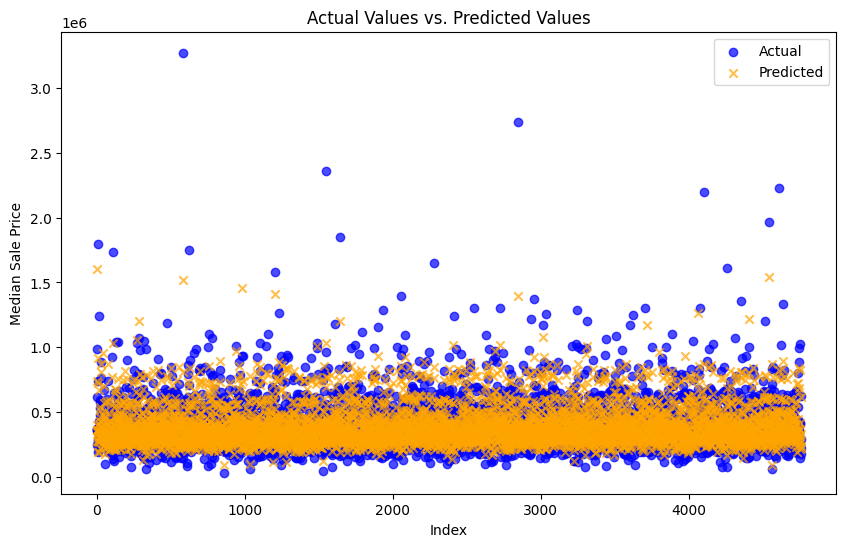

In [12]:
# Create a Scatter plot for 'Actual' vs 'Predicted' Results
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.7)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted", color="orange", alpha=0.7, marker='x')
plt.xlabel("Index")
plt.ylabel("Median Sale Price")
plt.title("Actual Values vs. Predicted Values")
plt.legend()
plt.show()

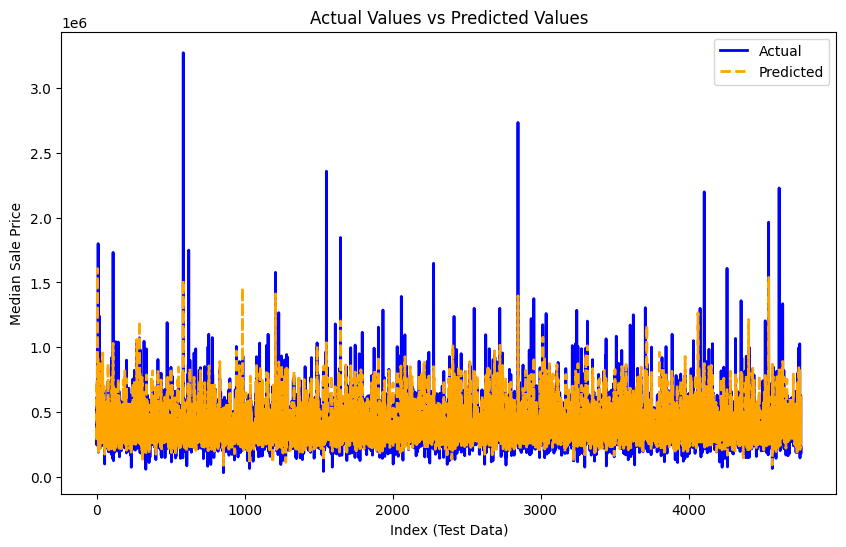

In [13]:
# Create a Line graph for 'Actual' vs 'Predicted' Results

# Use the range for the x-axis (indices of the test data)
plt.figure(figsize=(10, 6))
x = np.arange(len(y_test))  # Sequential index from 0 to the length of y_test

# Plot the two lines: Actual and Predicted
plt.plot(x, y_test.values, label='Actual', color='blue', linewidth=2)  
plt.plot(x, y_pred, label='Predicted', color='orange', linewidth=2, linestyle='--') 

# Add labels, title, and legend
plt.xlabel('Index (Test Data)')
plt.ylabel('Median Sale Price')
plt.title('Actual Values vs Predicted Values')
plt.legend()

# Show the plot
plt.show()

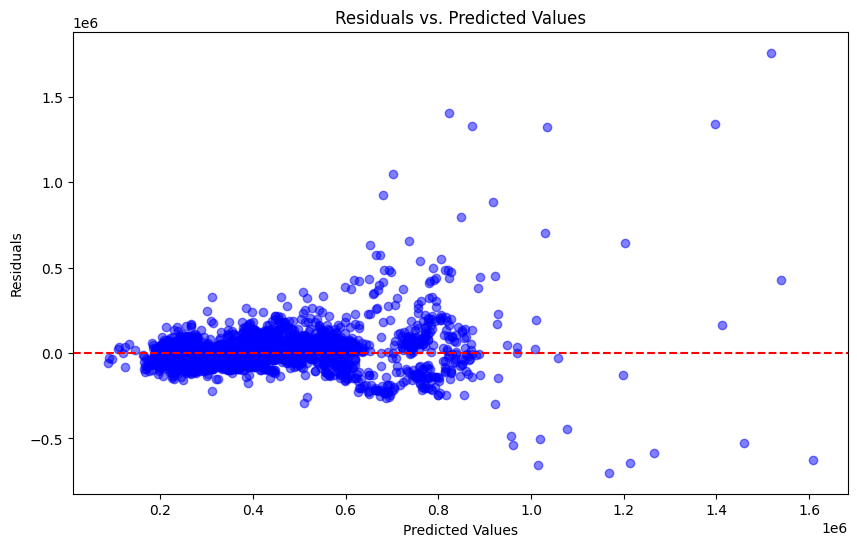

In [14]:
# Show a plot of the Resdiual Analysis

residuals = y_test - y_pred

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

## Conculsion: 
**Mean Squared Error: 9360116921.826487**  
**Mean Absolute Error: 51756.971365011486**  
**R^2 Score: 0.760306234063732**

In [21]:
# Calculate the difference and round to 2 decimal places to mirror actual dollar figure format

# Set up the rounding to 2 decimal places
actual_values = np.round(y_test.values, 2)  
predicted_values = np.round(y_pred, 2)  
differences = np.round(actual_values - predicted_values, 2)  

# Create the results DataFrame
results = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Difference': differences
})

# Save the results to a CSV file
results.to_csv('Resources/linear_regression_results.csv', index=False)

# Confirm the saved file contains properly rounded values
print("Results saved with Actual, Predicted and Difference columns!")


Results saved with Actual, Predicted and Difference columns!
